## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

For this, the Ricker classical populatiol model is used (this model shows near-chaotic dynamics). The ricker model is defined as:
$$ X_{t+1} = rX_t\exp(-X_t + e_t) $$
where $e_t$ is independent with $Normal(0,\sigma^2)$ distribution.
The process is not observed directly, instead samples with poisson distribution are observed.
$$ Y_t = Poisson(\phi X_t) $$
The Ricker model is an example of state space models.
We first only consider the time serie $X$ in order to study parameter estimation using approximated likelihood ratios on time series.
Here, the distribution is only conditioned by the previous value $p(x_t|x_{t-1})$. 
The joint probability distribution is then 
$$p_{x_t,...x_1}(x_t,...x_1;\theta) = \prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)} * p_{x_1}(x_1;\theta)$$

or if we keep $x_1$ deterministic, the conditional likelihood can be used instead 
$$\prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)}$$ . 

A recurrent neural network trained on the sequences $X' = [{x_t,x_{t-1}}]$ will approximate the posterior probability $p(y_t|x_t,x_{t-1})$ which is monotonic to the ratio $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$

Then to compute the likelihood ratio :
$$\frac{L(\theta_0)}{L(\theta_1)} = \prod_{t=1}^T \frac{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_0)}{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_1)}$$
 we can replace the ratios $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$  by the distribution of the score of the trained RNN $p(s([x_t,x_{t-1}])|\theta_0)/ p(s([x_t,x_{t-1}])|\theta_1)$.
 
Then, we can use maximum likelihood on the approximated likelihood ratios (keeping the ratio fixed) in order to estimate the parameters of the time series model.

We start by estimating the parameter $r$ from $\theta = (r,\sigma^2,\phi)$.



In [227]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [228]:
n_samples = 1000000
r_value = 3.8
sigma_2_value = 0.3**2
phi_value = 10.
r_bkg = 5.

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps // 50)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,50)])
        
        return_serie = time_serie[1:] - time_serie[:-1]
        
        return time_serie.reshape(time_serie.shape[0],1), sampled, return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[0]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [229]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = Ricker(r = theano.shared(r_bkg, name="r_1"),
            sigma_2 = theano.shared(0.3**2,name="sigma_2_1"),
            phi = theano.shared(10., name="phi_1")
            )
rng = np.random.RandomState(1234)

test_samples = 15000
max_len = 5

#X_true = np.array([p0.rvs(max_len, random_state = i) for i in range(test_samples)])
X_true = p0.rvs(test_samples,random_state=rng)
#print X_true

4.25493216603e-05 16.6460280317
1.20768097286e-23 61.9169761923


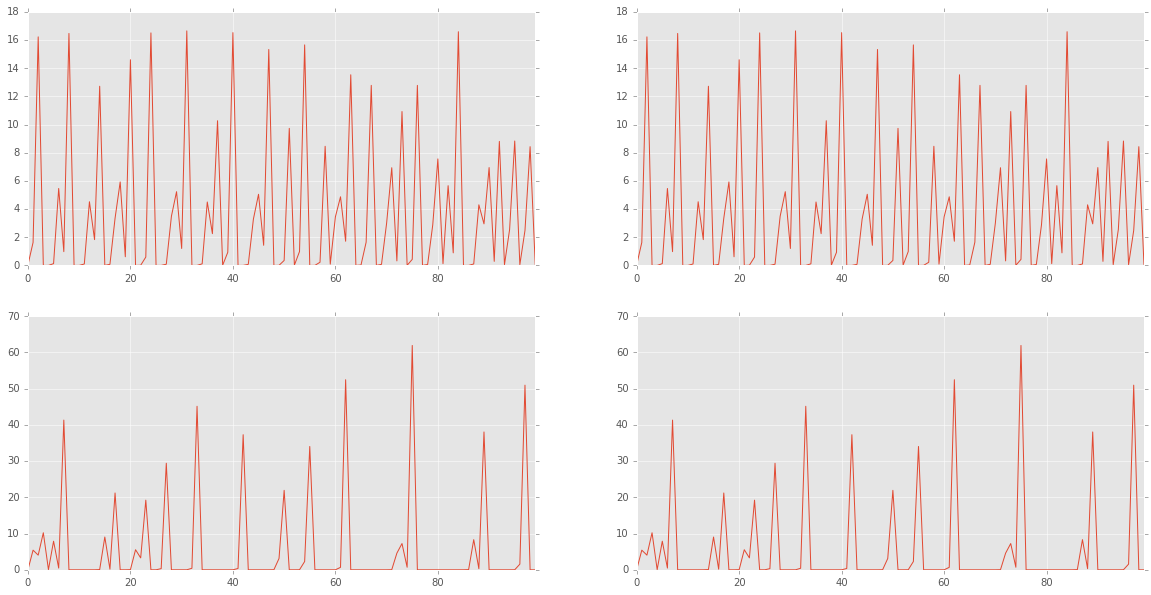

In [230]:
serie1 = p0.rvs(100).ravel()
serie2 = p1.rvs(100).ravel()
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [231]:
from carl.learning import make_parameterized_classification

X, y = make_parameterized_classification(
    p0, p1,
    n_samples, 
    [(shared_r, np.linspace(3.3,4.5, num=15))],
    random_state=1234)


In [232]:

X0_serie = []
y0_serie = []
X1_serie = []
y1_serie = []

X0 = X[y == 0]
X1 = X[y == 1]
for i in xrange(X0.shape[0]-max_len+1):
    # ensure that is from same time serie
    if X0[i][-1] == X0[i+max_len-1][-1]:
        X0_serie.append(X0[i:i+max_len])
    if X1[i][-1] == X1[i+max_len-1][-1]:
        X1_serie.append(X1[i:i+max_len])
X0_serie = np.array(X0_serie)
X1_serie = np.array(X1_serie)

X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

X_serie = np.vstack((
     X0_serie,
     X1_serie))
y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
y_serie[X0_serie.shape[0]:] = 1


In [233]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD


def make_model():
    model = Sequential()
    model.add(SimpleRNN(10,input_shape=(max_len,2)))
    model.add(Dropout(0.3))
    #model.add(Dense(5,activation='tanh'))
    #model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    #sgd = SGD(lr=0.01, clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model


clf = KerasClassifier(make_model, nb_epoch=10, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X_serie, y=y_serie)
#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/10
25s - loss: 0.1384
Epoch 2/10
25s - loss: 0.0893
Epoch 3/10
25s - loss: 0.0798
Epoch 4/10
25s - loss: 0.0746
Epoch 5/10
25s - loss: 0.0732
Epoch 6/10
25s - loss: 0.0713
Epoch 7/10
25s - loss: 0.0697
Epoch 8/10
27s - loss: 0.0691
Epoch 9/10
27s - loss: 0.0675
Epoch 10/10
26s - loss: 0.0674


In [234]:
print clf.predict_proba(X_serie)

[[  1.00000000e+00   2.24534571e-10]
 [  1.00000000e+00   2.52541188e-09]
 [  1.00000000e+00   1.07339986e-08]
 ..., 
 [  7.25436211e-03   9.92745638e-01]
 [  0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]]


In [235]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=30, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x29a2c910>,
            bins=30, cv='prefit', eps=0.1, method='histogram'),
        random_state=0)

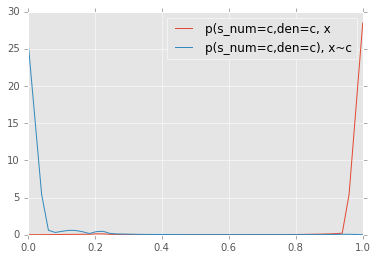

In [236]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0]
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [237]:

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
import pdb

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper
r_bkg = 5.
n_samples = 50000
def objective(theta, random_state=0, X_true=None):    
    #print(theta)
    shared_r.set_value(theta[0])
    serie1 = p0.rvs(n_samples)
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+1))
    X0[:,:-1] = serie1
    X0[:,-1] = theta
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=30))

    serie2 = p1.rvs(n_samples,random_state=random_state)
    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+1))
    X1[:,:-1] = serie2
    X1[:,-1] = r_bkg

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)
    X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
    X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+1))
    X_true_[:,:-1] = X_true
    X_true_[:,-1] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    X_true_serie = X_true_serie[np.random.choice(X_true_serie.shape[0],X_true_serie.shape[0],
                                                replace=False)]
    
    r = ratio.predict(X_true_serie, log=True)
    zeros = r[np.isinf(r)].shape
    #print r[np.isfinite(r)].shape
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
    #print zeros
    #print value

    return value, zeros[0]


In [238]:
n_points = 30
bounds = [(3.2,4.2)]

As = np.linspace(bounds[0][0],bounds[0][1], n_points)

approx_contours = np.zeros(len(As))
zeroes = np.zeros(len(As))
for i,a in enumerate(As):
    approx_contours[i], zeroes[i] = objective([a],X_true=X_true)

approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)


In [239]:
print(As)
print(approx_contours)

[ 3.2         3.23448276  3.26896552  3.30344828  3.33793103  3.37241379
  3.40689655  3.44137931  3.47586207  3.51034483  3.54482759  3.57931034
  3.6137931   3.64827586  3.68275862  3.71724138  3.75172414  3.7862069
  3.82068966  3.85517241  3.88965517  3.92413793  3.95862069  3.99310345
  4.02758621  4.06206897  4.09655172  4.13103448  4.16551724  4.2       ]
[   87.30937404    53.97562805   870.24111691  3065.18084885  2149.65400594
  1857.6162459   2260.94153069  4041.5917043   2239.42158528  9867.9959785
  4158.43354817  5987.14777998  4126.08544914  2551.77007191  1507.93768913
   561.15035535   168.62597472   121.81475645    35.92496451     0.
    23.03160493    85.21192522   144.49122825   320.14248698   487.86202244
   661.57736787   946.61387438  1347.37947769  1695.69041665  2342.40714738]


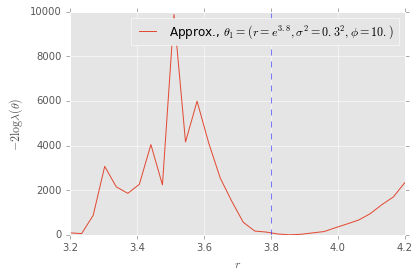

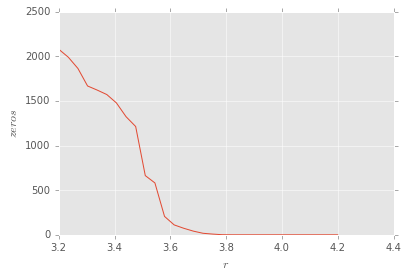

In [240]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios

ax.plot(As, approx_contours, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()

ax.legend()
#ax.set_ylim(-2., 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=r_value,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()
plt.plot(As, zeroes)
plt.xlabel(r"$r$")
plt.ylabel(r"$zeros$")
plt.show()

In [241]:
n_hist = 50
n_points = 30
bounds = [(3.6,4.2)]
As = np.linspace(bounds[0][0],bounds[0][1], n_points)

hist_values = np.zeros(n_hist)

for h in range(n_hist):
    shared_r.set_value(r_value)
    X_true = p0.rvs(15000,random_state=rng)
    approx_contours = np.zeros(len(As))
    zeroes = np.zeros(len(As))
    for i,a in enumerate(As):
        approx_contours[i], zeroes[i] = objective([a], X_true=X_true)
    min_value = As[np.argmin(approx_contours)]
    print '{0} '.format(min_value),
    hist_values[h] = min_value
#approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)


3.80689655172  3.88965517241  3.80689655172  3.84827586207  3.80689655172  3.8275862069  3.84827586207  3.84827586207  3.84827586207  3.84827586207  3.8275862069  3.80689655172  3.84827586207  3.80689655172  3.84827586207  3.84827586207  3.78620689655  3.80689655172  3.88965517241  3.86896551724  3.88965517241  3.84827586207  3.88965517241  3.84827586207  3.84827586207  3.84827586207  3.84827586207  3.80689655172  3.84827586207  3.84827586207  3.84827586207  3.84827586207  3.80689655172  3.91034482759  3.86896551724  3.84827586207  3.84827586207  3.84827586207  3.8275862069  3.84827586207  3.84827586207  3.84827586207  3.86896551724  3.86896551724  3.84827586207  3.80689655172  3.84827586207  3.86896551724  3.80689655172  3.8275862069 


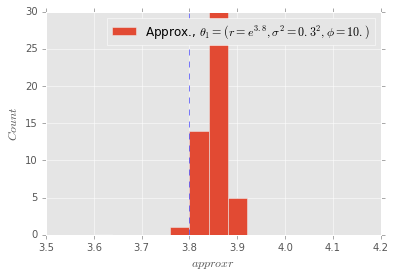

In [248]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios

ax.hist(hist_values, range=(bounds[0][0],bounds[0][1]), 
        label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$", bins=15)
ax.set_xlabel(r"$approx r$")
ax.set_ylabel(r"$Count$")
#plt.legend()

ax.legend()
#ax.set_ylim(-2., 14)
#ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=r_value,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model